# Today you are Machine Learning Engineer@ Epic Software Systems, and your task is to develop a new Recommendation System for Opthalmologists (eye doctors)!

### Diabetic Retinopathy (DR) is a pathology that impacts patients with Diabetes Mellitus 2, such that vision is compromised. Base paper on Automated classification of diabetic retinopathy:
https://ieeexplore.ieee.org/abstract/document/6680633
### Diabetic Retinopathy classification using modified AlexNet paper: https://www.sciencedirect.com/science/article/abs/pii/S0045790618334190
### Paper available at https://drive.google.com/file/d/1nl5tYA2jJ1Up_malA8uQmvwHu6UH0k-r/view?usp=sharing


### Automated classification of DR severity can help streamline the treatment process such that patients with higher severity are seen by the doctor first followed by the less severe patiets. This problem of DR clasification is significant since retinal images are biometrics (unique for each individual) which makes generalized modeling difficult and since 90% of the diabetic population that get imaged each year are have NO DR.

### This hard problem can be attacked using the tools of Deep Learning. Today we will show you how to use TensorFlow to construct and train a deep learning model on a small amount of DR data. In the clinic we would like to screen patients with different severity levels of the disease: patients that have NO DR (y=0), vs ones with mild DR (y=1), moderate DR (y=2) and severe DR (y=4). However, in this assignment we're going to make it even easier--the model will just do binary classification: normal images (patients without DR) will be labeled y=0, and those with any amount of DR as y=1.

### The purpose of this assignment is to show you the mechanics of using TensorFlow, not to say that what we present is the state-of-the-art in DR classification--far from it. But the ideas we use today are the first steps in an ML pipeline that can get quite-good performance in classifying diabetic retinopathy :)

### If using Colab, mount your Google Drive

### Change your working directory to the one containing this notebook

### Load Tensorflow and (optionally) TensorBoard

In [1]:
%load_ext tensorboard
from tensorflow import keras

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
#Load the libraries
from datetime import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

# Task 0: Get familiar with the data

Number of images = 1194
This image has DR = [3]
Maximum pixel value in image = 223


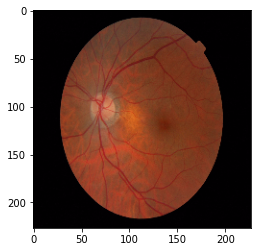

In [4]:
#Read the data and split into train and validation
from sklearn.model_selection import train_test_split
import h5py
f = h5py.File('1194_DR_smallimages.h5', 'r')  # this is wherever you stored the data
images = f['images']
labels = np.array(f['meta'])
print(f'Number of images = {len(labels)}')
#Plot the image and its label
num = 100
plt.imshow(images[num])
print(f"This image has DR = {labels[num]}")
print(f"Maximum pixel value in image = {np.max(images[num])}")

# Task 1: Data Pre-processing: 
1. Exploratory data analysis (Frequency of labels)
2. Normalization of images in [0, 1] range.
3. Generation of Training, Test data sets (66/33% split)

### Exercise: Plot a histogram illustrating the number of images corresponding to each of the 4 DR severity labels

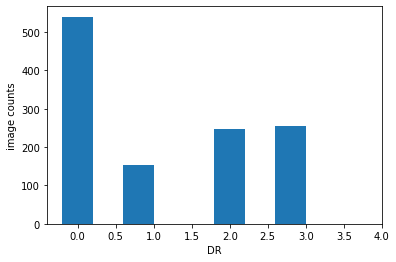

In [5]:
### START CODE HERE ###
plt.hist(labels, align='left', histtype='bar',range=(np.min(labels), np.max(labels)+1))
plt.xlabel("DR")
plt.ylabel("image counts")
plt.show()
### END CODE HERE ###

In [6]:
images

<HDF5 dataset "images": shape (1194, 227, 227, 3), type "|u1">

### Exercise: Normalize the images' pixel values so they fall in the range [0, 1]

Maximum pixel value in an image = 1.0


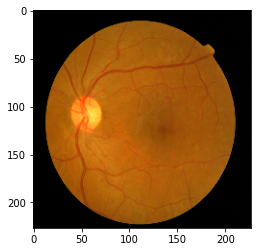

In [7]:
### START CODE HERE ###
from numpy import asarray
images_new = asarray(images)
images_new = images_new.astype('float32')
images_new /= 255.0
### END CODE HERE ###
plt.imshow(images_new[10])
print(f"Maximum pixel value in an image = {np.max(images_new[10])}")

### Exercise: Binarize the class labels. Set up 2 one-hot-encoded columns. Column 0 will contain a 1 for every row where the label is 0. Column 1 will contain a 1 for every row where the label is 1, 2, or 3.

### You might be wondering why we don't use a single one-hot-encoded column, since our problem is binary classification. This will become clear in Task 2, when we inspect the AlexNet architecture. 


In [9]:
### START CODE HERE ###
labels[labels >=1] = 1
one_hot_labels=to_categorical(labels,dtype ="uint8")### END CODE HERE ###

In [10]:
one_hot_labels

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

### Exercise: Perform a 2/3 - 1/3 train-test split on the data

In [11]:
### START CODE HERE ###
def split_data(mat, target, train_ratio):
    # mat is a matrix of features, target is a matrix of the classification targets
    train_split = int(train_ratio * len(images))
    X_train = mat[:train_split]
    X_test  = mat[train_split:]
    Y_train = target[:train_split]
    Y_test  = target[train_split:]
    return X_train, X_test, Y_train, Y_test

# Call the function you just defined to create the training and test data
X_train, X_test, Y_train, Y_test = split_data(images_new, one_hot_labels, 0.66)
### END CODE HERE ###

NameError: name 'images_new' is not defined

X_train.shape = (788, 227, 227, 3)
X_test.shape  = (406, 227, 227, 3)


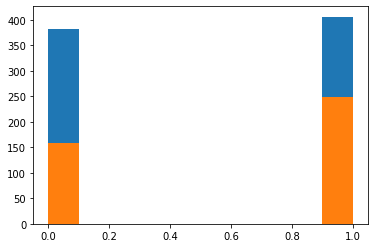

In [9]:
# Visualize the distribution of the binarized labels for both the training and test data
plt.hist(Y_train[:,1])
plt.hist(Y_test[:,1])
print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape  = {X_test.shape}')

# Task 2: Model Definition, classification and prediction (No regularization)

## AlexNet architecture

In [10]:
# Define the AlexNet model [This is given]
#1. Model Definition
class AlexNet(Sequential):
   def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                    padding= 'valid', activation= 'relu',
                    input_shape= input_shape, kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    
    
    self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None)) 
    

    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    

    self.add(Flatten())
    
    self.add(Dense(num_classes, activation= 'softmax'))

    self.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

### Since our problem involves binary classification, set `num_classes` to 2

In [11]:
num_classes = 2

### Exercise: Instantiate the model and summarize its architecture using the `.summary()` method of the model instance.

In [8]:
### START CODE HERE ###
model = AlexNet((np.shape(X_train)[2],np.shape(X_train)[2], 3), num_classes)
### END CODE HERE ###

NameError: name 'AlexNet' is not defined

In [13]:
model.summary()

Model: "alex_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885

Discuss with your classmates your interpretation of this summary, what do these numbers and names represent (it's okay to speculate)


### Exercise: Train the model, using its `.fit()` method. If you want to use TensorBoard to visualize how its properties evolve over the training epochs, you'll have to create a log directory and employ a TensorBoard callback. We include code for creating the callback below, but you'll have to pass it in as a parameter of the `.fit()` method. 
### In training the model, set aside 20% of the data as a validation set. Use a batch size of 20. Set the output verbosity to 1. Train the model for 40 epochs.

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from helper_functions_for_week5 import *

In [15]:
##### Comment the following two lines if you don't want to use tensorboard
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
#####

In [38]:
batch_size = 20
epochs = 40
training_history = model.fit(X_train,
                    Y_train,
                    batch_size=batch_size, 
                    epochs=epochs,
                    verbose=1, 
                    validation_split=0.8)
### END CODE HERE ###
print("Average test loss: ", np.average(training_history.history['loss']))

Train on 157 samples, validate on 631 samples
Epoch 1/40
157/157 [==============================] - 14s 90ms/sample - loss: 4.9831 - accuracy: 0.5669 - val_loss: 1947.4057 - val_accuracy: 0.5293
Epoch 2/40
157/157 [==============================] - 21s 132ms/sample - loss: 7.6397 - accuracy: 0.4904 - val_loss: 788.7354 - val_accuracy: 0.5293
Epoch 3/40
157/157 [==============================] - 21s 135ms/sample - loss: 9.2008 - accuracy: 0.5159 - val_loss: 173.8858 - val_accuracy: 0.5293
Epoch 4/40
157/157 [==============================] - 27s 171ms/sample - loss: 6.7724 - accuracy: 0.5096 - val_loss: 54.3731 - val_accuracy: 0.5293
Epoch 5/40
157/157 [==============================] - 23s 145ms/sample - loss: 4.1730 - accuracy: 0.6433 - val_loss: 37.7994 - val_accuracy: 0.5293
Epoch 6/40
157/157 [==============================] - 24s 152ms/sample - loss: 4.7212 - accuracy: 0.5860 - val_loss: 24.7347 - val_accuracy: 0.5309
Epoch 7/40
157/157 [==============================] - 23s 147ms

### Exercise: Display loss and accuracy for both the training and validation data. You should find the provided functions in `helper_functions_for_week5.py` useful. 

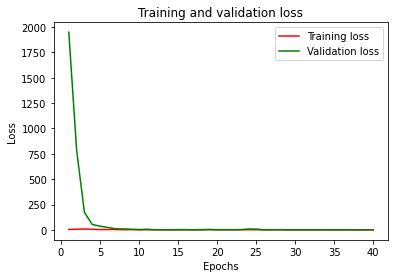

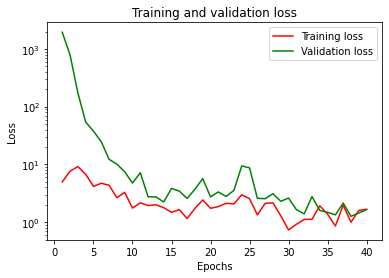

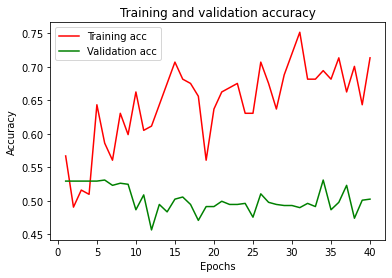

In [39]:
### START CODE HERE ###

print_loss_history(training_history.history)
print_loss_history(training_history.history, logscale=True)
print_accuracy_history(training_history.history)


### END CODE HERE ###


In [40]:
# if you used tensorboard callbacks, try launching tensorboard to view the logs:
# If developing locally: `tensorboard --logdir <THIS_DIRECTORY>/logs
# If developing on Colab: `%tensorboard --logdir logs`

### Exercise: Generate predictions with the test data

In [41]:
### START CODE HERE ###
prediction_values = model.predict(X_test, verbose=True)
prediction_values=np.argmax(prediction_values, axis=1)
### END CODE HERE ###

406/406 [==============================] - 5s 13ms/sample


### Exercise: Evaluate the predictions against the Number 1 column of `Y_test`

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,precision_score,recall_score
### START CODE HERE ###


# Import the necessary functions from sklearn.metrics
print(f'Accuracy = {accuracy_score(Y_test[:, 1], prediction_values)}')
print(f'F1 = {f1_score(Y_test[:, 1], prediction_values)}')
print(f'Precision = {precision_score(Y_test[:,1], prediction_values)}')
print(f'Recall = {recall_score(Y_test[:, 1], prediction_values)}')
# Display the confusion matrix
confusion_matrix(Y_test[:, 1], prediction_values)
### END CODE HERE ###

Accuracy = 0.4630541871921182
F1 = 0.441025641025641
Precision = 0.6056338028169014
Recall = 0.3467741935483871


array([[102,  56],
       [162,  86]], dtype=int64)

What do you notice about the performance of this model, especially as it relates to the difference between train and validation accuracy?

### Next, visualize the activations.
Source: https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras

### Exercise: Extract the activations for each layer in our AlexNet model

In [43]:
### START CODE HERE ###
# Use a list comprehension to extract the output of each layer in the model
layer_outputs =  [layer.output for layer in model.layers]
# Define a new model with the same input shape as the original model 
# and layer_outputs as its outputs
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get all the activations by calling the predict() method on the number 10 image 
# in X_train. Make sure to reshape the image so it has a new 0 axis of length 1.
activations = activation_model.predict(X_train[10].reshape(1,227,227,3))
### END CODE HERE ###

### Exercise: Display the first 64 activations of the second model layer (layer index 1) in an 8 x 8 grid. Again, the helper functions are your friends.

### Exercise: Display the first 64 activations of the 11th model layer (layer index 10) in an 8 x 8 grid

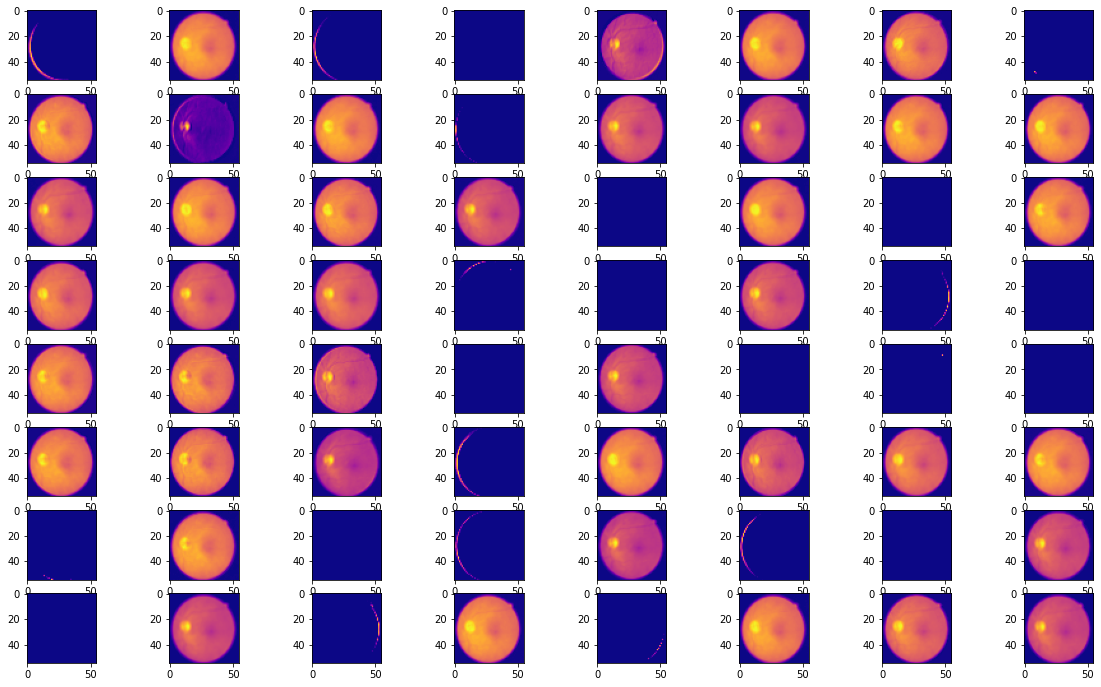

In [44]:
import helper_functions_for_week5
### START CODE HERE ###

display_activation(activations, 8, 8, 1) #For layer 2
### END CODE HERE ###

# Comment on the activated feature maps for early layers to later layers. What patterns do you observe?

# Task 3: Regularization by Data Augmentation [Instructor Led]

## We can regularize our model (and, in doing so, hopefully improve it) by augmenting our image data. Image augmentation includes transformations such as rotation, translation, reflection, shearing, and color permutation. TensorFlow provides the ImageDataGenerator class to perform image augmentation in memory; by default, your local storage won't save the newly generated images.

In [56]:
# Create a Data Generator
data_gen_args = dict( 
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.2,
    channel_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    data_format="channels_last",
) # add in the desired parameters of an ImageDataGenerator 
image_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(X_train)
BATCH_SIZE = X_train.shape[0]

### Initialize data generator for training/validation and test data sets

In [57]:
train_generator = image_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE)
test_generator = image_datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE)

### Import libraries and set useful parameters

In [58]:
seed = 0
aug_batch_size = 6

## Step 1: Understanding the data augmentation process
Images are randomly generated with the options provided in the image data generator

Epoch 0
(6, 227, 227, 3)


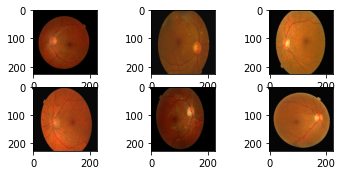

[[1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]
Epoch 1
(6, 227, 227, 3)


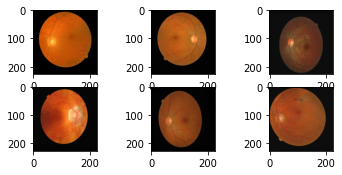

[[1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]]
Epoch 2
(6, 227, 227, 3)


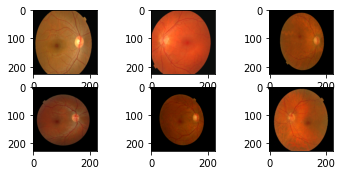

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]
Epoch 3
(6, 227, 227, 3)


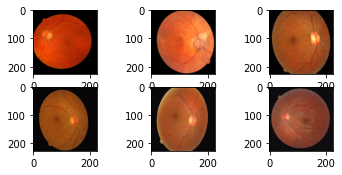

[[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]]
Epoch 4
(6, 227, 227, 3)


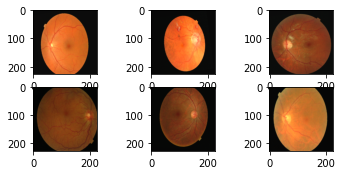

[[1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]]


In [59]:
for e in range(5):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in image_datagen.flow(X_train, Y_train, batch_size=aug_batch_size):
        print(x_batch.shape)
        for i in range(0, aug_batch_size):
            plt.subplot(330+1 + i)
            plt.imshow(x_batch[i], cmap=plt.get_cmap('gray'))
        

        plt.show()
        print(y_batch)
        break

## Step 2: Using augmented data to Train the model
### Visualize using tensorboard

### Method 1: Iterate through randomized `(X, y)` batches generated by `train_generator` and fit AlexNet to each one

In [60]:
model_reg = AlexNet((np.shape(X_train)[1],np.shape(X_train)[2], 3), num_classes)

In [61]:
#Method 1: Randomized batches
EPOCHS = 40
reg_history_loss = []
reg_history_vloss = []
reg_history_accuracy = []
reg_history_val_accuracy = []
# Start training
for e in range(EPOCHS):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in train_generator:
        reg_hist = (model_reg.fit(x_batch, y_batch,validation_split=0.2, verbose=1))
        batches += 1
        reg_history_loss.append(reg_hist.history['loss'])
        reg_history_vloss.append(reg_hist.history['val_loss'])
        reg_history_accuracy.append(reg_hist.history['accuracy'])
        reg_history_val_accuracy.append(reg_hist.history['val_accuracy'])
        if batches >= len(X_train) / BATCH_SIZE:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break   


#^ If you have issues with your Colab instance running out of memory, you may have to delete some 
#  previously-created variables such as `model` object holding the unregularized version of AlexNet

Epoch 0
Train on 630 samples, validate on 158 samples
630/630 [==============================] - 47s 74ms/sample - loss: 15.5310 - accuracy: 0.4730 - val_loss: 8055.4858 - val_accuracy: 0.4873
Epoch 1
Train on 630 samples, validate on 158 samples
630/630 [==============================] - 46s 74ms/sample - loss: 5.7747 - accuracy: 0.5302 - val_loss: 1925.1514 - val_accuracy: 0.4873
Epoch 2
Train on 630 samples, validate on 158 samples
630/630 [==============================] - 46s 73ms/sample - loss: 5.6883 - accuracy: 0.4937 - val_loss: 149.9001 - val_accuracy: 0.5063
Epoch 3
Train on 630 samples, validate on 158 samples
630/630 [==============================] - 45s 72ms/sample - loss: 5.3183 - accuracy: 0.4810 - val_loss: 113.2593 - val_accuracy: 0.5506
Epoch 4
Train on 630 samples, validate on 158 samples
630/630 [==============================] - 45s 72ms/sample - loss: 4.9888 - accuracy: 0.5302 - val_loss: 27.3812 - val_accuracy: 0.5443
Epoch 5
Train on 630 samples, validate on 1

ResourceExhaustedError:  OOM when allocating tensor with shape[32,55,55,96] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node alex_net_3/conv2d_15/Relu (defined at <ipython-input-61-1441d599cb05>:12) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_23247]

Function call stack:
distributed_function


### Plot the losses and accuracies for both training and validation data

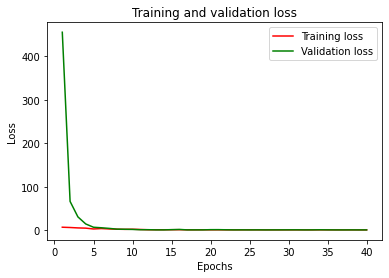

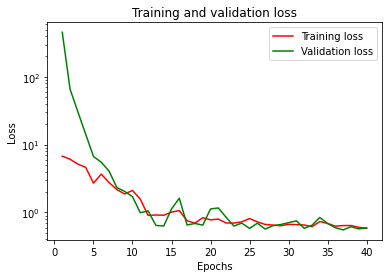

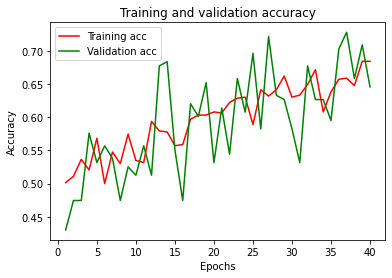

In [53]:
#Print the loss and accuracies
print_loss_history({'loss': reg_history_loss, 'val_loss': reg_history_vloss})
print_loss_history({'loss': reg_history_loss, 'val_loss': reg_history_vloss}, logscale=True)
print_accuracy_history({'accuracy': reg_history_accuracy, 'val_accuracy': reg_history_val_accuracy})


### Method 2: Pass `train_generator` into the model's `fit()` method directly and abstract away the looping

In [54]:
#Method 2
model_reg_2 = AlexNet((np.shape(X_train)[1],np.shape(X_train)[2], 3), num_classes)
reg_history = model_reg_2.fit(
    train_generator,
    steps_per_epoch=50,
    verbose=1, 
    epochs=2,
    
#    callbacks=[tensorboard_callback]
)

print("Average test loss: ", np.average(reg_history.history['loss']))

  ...
    to  
  ['...']
Train for 50 steps
Epoch 1/2
 1/50 [..............................] - ETA: 1:02:29 - loss: 0.9522 - accuracy: 0.5381Average test loss:  0.9521931409835815


In [55]:
print_loss_history(reg_history.history)
print_loss_history(reg_history.history, logscale=True)
print_loss_accuracy(reg_history.history)

KeyError: 'val_loss'

Now we can save the whole trained model to disk:

In [62]:
model_reg_dir = "reg_model.h5"
model_reg.save(model_reg_dir)  # or model_reg_2 if that's the one you trained

In [63]:
# %tensorboard --logdir logs

# Task 4: Evaluate the Regularized Model and Report Results

### Exercise: Compute the evaluation metrics

In [64]:
prediction_values_reg = np.argmax(model_reg.predict(X_test), axis=-1)

In [65]:
### START CODE HERE ###
print(f'Accuracy = {accuracy_score(Y_test[:, 1], prediction_values_reg)}')
print(f'F1 = {f1_score(Y_test[:, 1], prediction_values_reg)}')
print(f'Precision = {precision_score(Y_test[:, 1], prediction_values_reg)}')
print(f'Recall = {recall_score(Y_test[:, 1], prediction_values_reg)}')
print(f'Confusion matrix = {confusion_matrix(Y_test[:, 1], prediction_values_reg)}')
### END CODE HERE ###

Accuracy = 0.6108374384236454
F1 = 0.6425339366515838
Precision = 0.7319587628865979
Recall = 0.5725806451612904
Confusion matrix = [[106  52]
 [106 142]]


# Visualize activations from early layers after regularization and report results

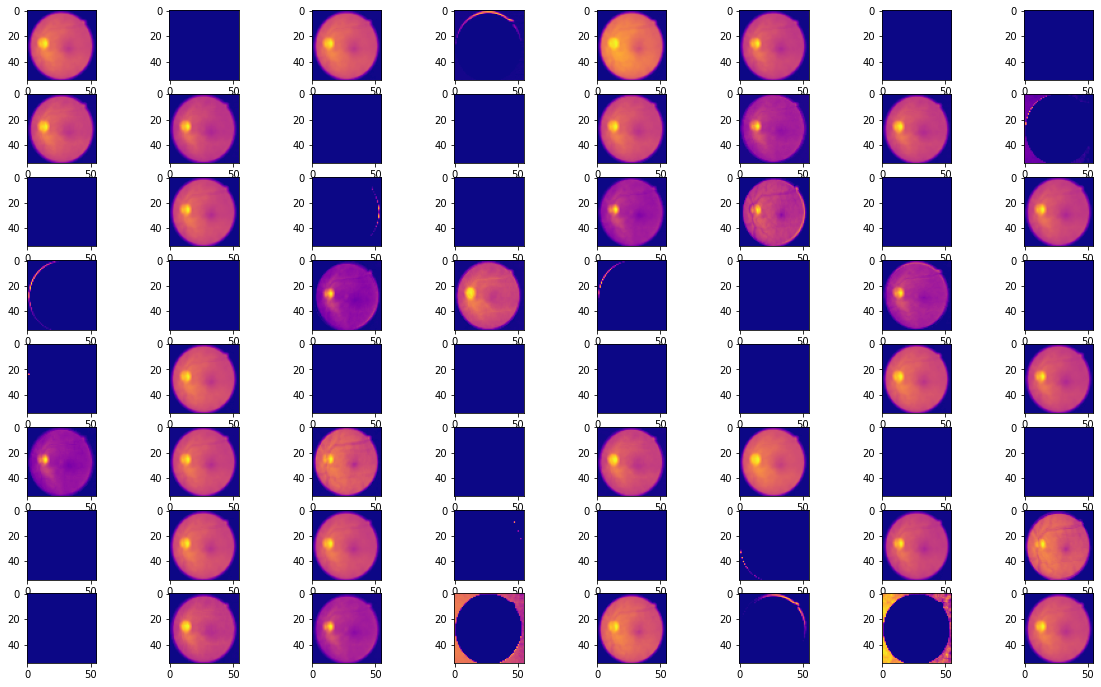

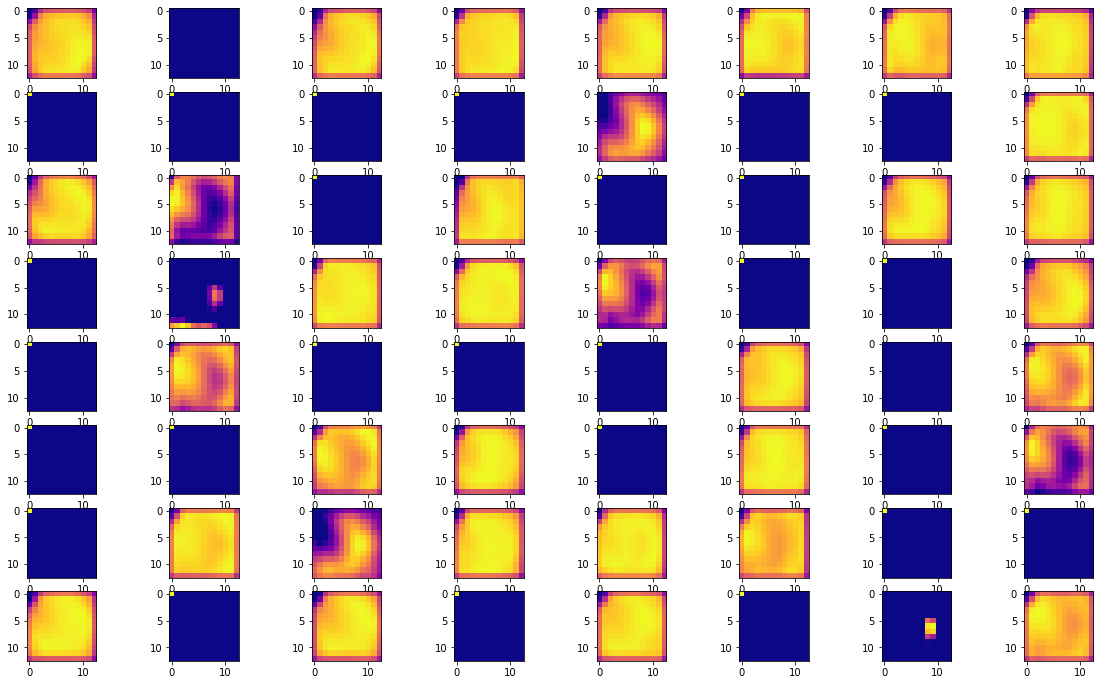

In [69]:
### START CODE HERE ###
layer_outputs = [layer.output for layer in model_reg.layers]
activation_model = Model(inputs=model_reg.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[10].reshape(1,227,227,3))
### END CODE HERE ##
display_activation(activations, 8, 8, 1) #For layer 2
display_activation(activations, 8, 8, 11) #For layer 10